# ✍️ Mastering Video Scene Indexing: A Deep Dive into Prompt Engineering 

<a href="https://colab.research.google.com/github/video-db/videodb-cookbook/blob/main/guides/multimodal/Prompt_Experiments_and_Benchmarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction 

As developers working on video processing, we often face challenges in accurately indexing and describing complex scenes. This blog post explores how strategic prompt engineering can significantly enhance our ability to extract detailed information from video frames, opening up new possibilities for advanced video search and analysis.

## Goal of the Experiment:

---

Our primary objective was to demonstrate how refined prompts can significantly improve search results and information extraction from video content. We aimed to create a system capable of accurately identifying objects, actions, and even emotions in various video scenes. For this particular experiment, we used video footage from a [dog show](https://www.youtube.com/watch?v=_T3n-2zOrZQ), featuring various breeds walking down a runway with their handlers, surrounded by spectators and photographers. Our goal was to create prompts that could answer detailed queries like `"Show me the happiest moments featuring a Golden Retriever"`  with high precision.

## Setup
---

### 📦  Installing packages 

In [ ]:
%pip install videodb matplotlib

### 🔑 API keys
Before proceeding, ensure access to [VideoDB](https://videodb.io). If not, sign up for API access on the respective platforms.

> Get your API key from [VideoDB Console](https://console.videodb.io). ( Free for first 50 uploads, **No credit card required** ) 🎉

In [1]:
import os

os.environ["VIDEO_DB_API_KEY"] = ""

## Guide Walkthrough

---

### 📋 Step 1: Connect to VideoDB

Gear up by establishing a connection to VideoDB 

In [2]:
from videodb import connect

# Connect to VideoDB using your API key
conn = connect()
coll = conn.get_collection()

### 🎬 Step 2: Upload the Video 

In [3]:
video = coll.upload(url="https://www.youtube.com/watch?v=_T3n-2zOrZQ")

### 📸️ Step 3: Extracting Scenes without needing to index

In [4]:
from videodb import SceneExtractionType

# Example: Time-based extraction every 15 seconds
scene_collection = video.extract_scenes(
    extraction_type=SceneExtractionType.time_based,
    extraction_config={"time": 15, "select_frames": ["first", "middle", "last"]},
)

#### `Note`: Image upload might take time (5s-60s). Re-fetch the scene collection if `Frame.url` is None

In [5]:
scene_collection = video.get_scene_collection(scene_collection.id)
print(scene_collection.scenes[0].frames[0].url)

https://storage.googleapis.com/videodb-dev.appspot.com/media/u-cc36fd41-567b-4ab5-8b05-d215437275f3/m-d6d877a5-33e4-4f3c-bf9a-bf6ebefab68d/frames/frm-scn-tt15sflm-0.0-15.015-0.0/img-96e571ba-40aa-48b6-a605-71b89527a22f.png


### ✍️ Step 4: Experimenting with Prompts

Frame-Level vs Scene-Level Prompting:

In our experiment, we explored both frame-level and scene-level prompting:

* Frame-level prompts focus on extracting information from individual frames.
* Scene-level prompts analyze a series of frames to describe the overall action.

Important Considerations:

1. Computational Cost: Frame-level descriptions, while providing granular detail, are computationally heavy and potentially costly. It's not always necessary or efficient to use them for every use case.
2. Strategic Approach: A recommended strategy is to use frame prompts as a tuning mechanism. By testing and refining frame-level prompts, we can identify the most effective way to extract information from the vision model. Once optimized, we can incorporate these insights into scene-level prompts, potentially achieving high accuracy without the computational overhead of frame-by-frame analysis.



Let's walk through our prompt iterations and their outputs:

### Frame-level Prompts:

#### 1️⃣ Frame Prompt: Basic animal identification

In [ ]:
frame_prompt1 = """
You will be provided with an image. Your task is to identify and describe the animals in the image.
1. Identify Animals: List distinct animals in the image.
2. Describe animals: Provide a brief description of each animal, including breed, color, and any other notable features.

Output should be a list of objects.
Expected Output:
[{"name": "dog", "context": "a black dog with thick fur and a yellow collar is jumping onto the couch"}]
"""

print("Results for Basic Animal Identification Prompt:")
# Limiting to first 2 scenes for brevity
for scene in scene_collection.scenes[:2]:
    for frame in scene.frames:
        try:
            description = frame.describe(prompt=frame_prompt1)
            print("\n--------------")
            print(frame.frame_time)
            print(description)
        except Exception as e:
            print(f"Error describing frame at {frame.frame_time}: {e}")

`Note` : This output lacked specificity in breed identification and environmental context. Our next prompt aims to address these issues.

#### 2️⃣ Enhanced breed identification and spatial information

In [ ]:
frame_prompt2 = """
You will be provided with an image. Your task is to identify the animals and their breeds in the image.
1. Identify Animals: List distinct animals and their breed in the image.
2. Describe the environment: Provide a brief description of the interaction between the animals and the objects or the environment around them.

Output should be a list of objects.
Expected Output:
[{"name": "Dog - Poodle", "context": "A Poodle being led down a carpeted path by a handler in the green dress, participating in what appears to be a dog show."}]
"""

print("Results for Enhanced Breed Identification Prompt:")
for scene in scene_collection.scenes[:2]:  # Limiting to first 2 scenes for brevity
    for frame in scene.frames:
        try:
            description = frame.describe(prompt=frame_prompt2)
            print("\n--------------")
            print(frame.frame_time)
            print(description)
        except Exception as e:
            print(f"Error describing frame at {frame.frame_time}: {e}")

`Note` : This output significantly improved breed identification and provided more environmental context. With this satisfactory frame-level output, we're now ready to incorporate these learnings into scene-level prompts. 

However, let's first examine what a generic scene-level prompt can achieve without the added context from our frame-level experiments.

### Scene-level:

#### 1️⃣ Basic scene-level prompt

In [ ]:
scene_prompt1 = """
You will be provided with a series of images. Your task is to view all images together and describe the overall story or scene in the best possible way.

Expected Output:
- A detailed story or scene description.
- A list of objects and actions in each image.

Example Output:
{
  "scene_story": "A person is cooking in the kitchen and then someone rings the doorbell.",
  "images": [
    {"description": "Someone is cooking in the kitchen."},
    {"description": "Someone rings the doorbell."}
  ]
}

Strictly limit your response to a maximum of 1200 characters.
"""

print("Results for Basic Scene-Level Prompt:")
for scene in scene_collection.scenes[:2]:  # Limiting to first 2 scenes for brevity
    try:
        description = scene.describe(prompt=scene_prompt1)
        print("\n--------------")
        print(f"{scene.start}-{scene.end}")
        print(description)
    except Exception as e:
        print(f"Error describing scene starting at {scene.start}: {e}")

`Note` : This generic scene-level prompt provided a basic structure but lacked the detailed breed identification and specific actions we achieved with our frame-level prompts. Our next iteration aims to incorporate these learnings.

#### 2️⃣ Combining frame-level specifications in scene-level prompt

In [ ]:
scene_prompt2 = """
You will be provided with a series of images. Your task is to view all images together and describe the overall story or scene in the best possible way.
For each image, your task is to identify the animals and their breeds in the image.
1. Identify the animals present in the frame with specifications about their colour and breed, and any other notable features.
2. Describe the environment: Provide a brief description of the interaction between the animals and the objects or the environment around them.

Expected Output:
- A detailed story or scene description.
- A list of objects and actions in each image.

Strictly limit your response to a maximum of 1200 characters.
"""

print("Results for Enhanced Scene-Level Prompt:")
# Limiting to first 2 scenes for brevity
for scene in scene_collection.scenes[:2]:
    try:
        description = scene.describe(prompt=scene_prompt2)
        print("\n--------------")
        print(f"{scene.start}-{scene.end}")
        print(description)
    except Exception as e:
        print(f"Error describing scene starting at {scene.start}: {e}")

`Note`: This prompt successfully captured both the specific breeds and the overall scene dynamics, providing a detailed and accurate description. However, the format could be more structured for easier parsing and use in applications. Our final iteration addresses this.

#### 3️⃣ Structured JSON output with emotional states

In [ ]:
scene_prompt3 = """
You will be provided with a series of images from a dog show. Your task is to describe the scene based on these sequential images. Focus on identifying the breeds and describing the key actions.

For each image, your task is to:
1. Identify the animals present in the frame, including their breed, color, and any notable features.
2. Describe the actions of the animals and any interactions with the environment or other animals.
3. Highlight any emotional expressions or notable moments.

Output should be a structured JSON with the following format:
{
  "scene_story": "Brief overview of the scene",
  "images": [
    {
      "frame_time": "Time of the frame in mm:ss format",
      "breeds": [{"breed": "Golden Retriever", "color": "golden"}],
      "actions": "Description of the actions and interactions",
      "emotion": "Observed emotion or notable moment"
    },
    ...
  ]
}

"""

print("Results for Structured JSON Output Prompt:")
for scene in scene_collection.scenes[:2]:  # Limiting to first 2 scenes for brevity
    try:
        description = scene.describe(prompt=scene_prompt3)
        print("\n--------------")
        print(f"{scene.start}-{scene.end}")
        print(description)
    except Exception as e:
        print(f"Error describing scene starting at {scene.start}: {e}")

### 🗂️ Step5: Describe All Scenes & Index

In [ ]:
from videodb import SceneExtractionType

# Index Scenes
index_id = video.index_scenes(
    extraction_type=SceneExtractionType.time_based,
    extraction_config={"time": 15, "select_frames": ["first", "middle", "last"]},
    prompt=scene_prompt3,
    name="Detailed Dog Breed Identifier",
)
scene_index = video.get_scene_index(index_id)
print(scene_index)

### Step 6 : 🔍 Search



In [12]:
from videodb import IndexType

# Search using the indexed scenes
res = video.search(
    query="Show me the happiest moments with the Golden Retreiver",
    index_type=IndexType.scene,
    index_id=index_id,
    score_threshold=0.1,
    dynamic_score_percentage=100,
)
res.play()

'https://console.videodb.io/player?url=https://dseetlpshk2tb.cloudfront.net/v3/published/manifests/59482540-2343-47e4-be74-e783dbb5c8ea.m3u8'

## Benchmarking 
---

### Define Score Evaluation Functions

In [48]:
from videodb import SearchType, IndexType

def calculate_overlap(true_start, true_end, prediction_start, prediction_end):
    overlap_start = max(true_start, prediction_start)
    overlap_end = min(true_end, prediction_end)
    return max(0, overlap_end - overlap_start)

def simple_evaluation(ground_truth, predictions):
    total_retrieved = len(predictions)
    total_relevant = len(ground_truth)
    total_relevant_retrived = 0

    for ground_truth_start, ground_truth_end in ground_truth:
        ground_truth_interval_duration = ground_truth_end - ground_truth_start
        processed = False
        for prediction_start, prediction_end in predictions:
            overlap = calculate_overlap(ground_truth_start, ground_truth_end, prediction_start, prediction_end)
            if overlap > 0:
                if not processed:
                    total_relevant_retrived += 1
                    processed = True
    precision = total_relevant_retrived / total_retrieved if total_retrieved else 0
    recall = total_relevant_retrived / total_relevant if total_relevant_retrived else 0

    return {
        "precision": precision,
        "recall": recall,
    }

def evaluate_prompts(ground_truth, query, prompts):
    test_results = {}
    for prompt_name, prompt_obj in prompts.items():
        print("\n"+"-"*50)
        print(f"📊 Benchmarking for {prompt_name} : {prompt_obj['index_id']}")
        print(f"  Query : {query}")
        print(f"  Ground Truth : {ground_truth}")
        result = video.search(
            index_type=IndexType.scene,
            search_type=SearchType.semantic,
            scene_index_id=prompt_obj['index_id'],
            query=query,
            stitch=False,
        )
        predictions = [(shot.start, shot.end) for shot in result.shots]
        print(f"  Predictions: {predictions}")
        res = simple_evaluation(ground_truth=ground_truth, predictions=predictions)
        print(f"  Eval Results : {res}")
        test_results[prompt_name] = res
        print("-"*50)
    return test_results


### Helper Functions to analyze results

In [60]:
import matplotlib.pyplot as plt

def plot_test_results(results, query):
    # Extracting the values
    labels = list(results.keys())
    precision = [results[label]['precision'] for label in labels]
    recall = [results[label]['recall'] for label in labels]

    # Plotting
    x = range(len(labels))

    plt.figure(figsize=(10, 5))

    plt.plot(x, precision, marker='o', linestyle='-', color='b', label='Precision')
    plt.plot(x, recall, marker='o', linestyle='-', color='g', label='Recall')

    # Adding labels and title
    plt.xlabel(f"Query : {query}")
    plt.ylabel('Scores')
    plt.title('Precision and Recall for Different Prompts')
    plt.xticks(x, labels, rotation=45, ha='right')

    # Adding legend
    plt.legend()

    # Display plot
    plt.tight_layout()
    plt.show()

### Define Prompt and Index for each Prompt

In [14]:
prompts = {
    "Basic Scene-Level Prompt": {"prompt" : scene_prompt1},
    "Enhanced Scene-Level Prompt": {"prompt" : scene_prompt2},
    "Structured JSON Output": {"prompt" : scene_prompt3},
}

for prompt_name, prompt_obj in prompts.items():
    print("Indexing for Prompt : ", prompt_name)
    index_id = video.index_scenes(
        extraction_type=SceneExtractionType.time_based,
        extraction_config={"time": 15, "select_frames": ["first", "middle", "last"]},
        prompt=prompt_obj["prompt"], 
        name=prompt_name,
    )
    prompt_obj["index_id"] = index_id
    scene_index = video.get_scene_index(index_id)

### Prepare Test bed, Ground Truth, and Evaulate

In [63]:
ground_truth_1 = [(150.15, 165.165), (180.18, 195.195), (210.21, 225.225), (240.24, 255.255)]
test_query_1 = "Happiest moments featuring a Golden Retreive"
test_results_1 = evaluate_prompts(ground_truth_1, test_query_1, prompts) 


--------------------------------------------------
📊 Benchmarking for Basic Scene-Level Prompt : f24f6ded567237c6
  Query : Happiest moments featuring a Golden Retreive
  Ground Truth : [(150.15, 165.165), (180.18, 195.195), (210.21, 225.225), (240.24, 255.255)]
  Predictions: [(255.255, 270.27)]
  Eval Results : {'precision': 0.0, 'recall': 0}
--------------------------------------------------

--------------------------------------------------
📊 Benchmarking for Enhanced Scene-Level Prompt : be21df0226f85169
  Query : Happiest moments featuring a Golden Retreive
  Ground Truth : [(150.15, 165.165), (180.18, 195.195), (210.21, 225.225), (240.24, 255.255)]
  Predictions: [(180.18, 195.195)]
  Eval Results : {'precision': 1.0, 'recall': 0.25}
--------------------------------------------------

--------------------------------------------------
📊 Benchmarking for Structured JSON Output : 009a8b1cfd0dd62c
  Query : Happiest moments featuring a Golden Retreive
  Ground Truth : [(150.15, 1

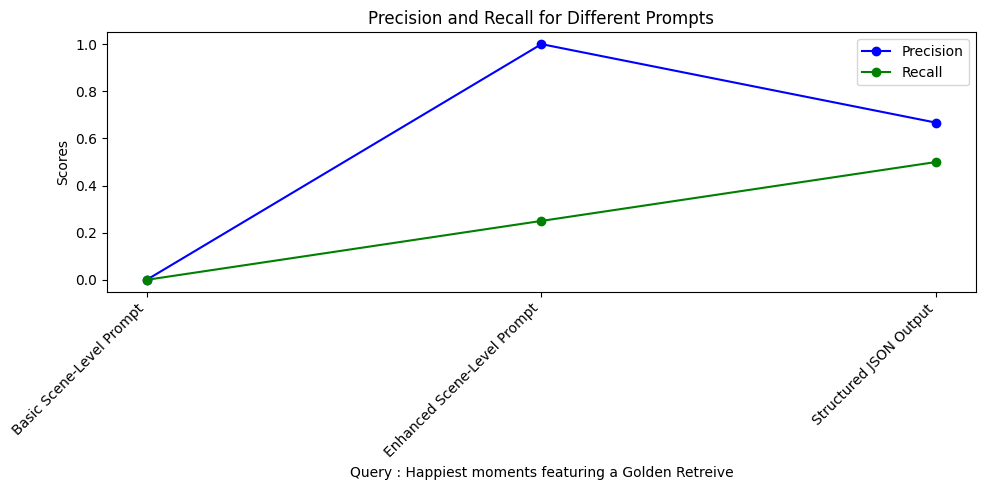

In [62]:
plot_test_results(test_results_1, test_query_1)